# The Generation of samples follows the method explained in the following link:

https://math.stackexchange.com/questions/1218718/how-do-we-sample-from-a-gaussian-process

In [ ]:
import torch 
import torch.nn as nn
from torch.autograd import grad
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn  as sns
np.random.seed(int(time.time()))
torch.manual_seed(int(time.time()))
device = torch.device("cpu")
print(torch.__version__)
print(torch.cuda.is_available())

1.11.0+cu113
False


In [ ]:

class GP_1d(nn.Module):
    def __init__(self,
                nugget_size = 1e-6,
                lengthscale=0.2,
                #noise_level = 0.1,
                sigma = 0.1,
                M = 10,
                device = device):

        super(GP_1d, self).__init__()
        
        self.device = device
        self.nugget_size = nugget_size
        self.M = M
        self.lengthscale = nn.Parameter(torch.tensor([lengthscale],dtype=torch.float64), requires_grad=True)
        self.Xs = torch.linspace(-1,1,self.M,dtype= torch.float64,device=self.device).view(-1,1)
        self.sigma = sigma 
        
        
        self.Ys = self.mean_func(self.Xs) 
        self.Ys = self.Ys #+ noise_level*torch.randn_like(self.Ys)
        self.nugget = self.nugget_size*torch.eye(self.M,dtype = torch.float64,device = self.device)
        

    def mean_func(self,x):
        return torch.sin(np.pi*x)

    def make_Theta(self):
        
        Theta = self.K11(self.Xs,self.Xs.swapaxes(0,1))+self.nugget
        
        return Theta
    
    
    def K(self, x, y):
        # Covariance function
        return (self.sigma**2)*torch.exp(-0.5*((self.lengthscale**(-2))*(x-y)**2))

    def K11(self,x ,y):
        xcombo = x.repeat(1,y.shape[1])
        ycombo = y.repeat(x.shape[0],1)
        
        return self.K(xcombo,ycombo)
    def make_samples(self):
        Theta = self.make_Theta()
        L = torch.linalg.cholesky(Theta+self.nugget)
        Zs = torch.randn(self.M,dtype = torch.float64,device=self.device).view(-1,1)
        return self.Ys + L@Zs

    

    def predict(self,x):
        
        Theta = self.make_Theta()
        x = x.clone()#.detach().to(self.device).requires_grad_(True)

        y = self.Xs.swapaxes(0,1)
        xcombo = x.repeat(1,y.shape[1])
        ycombo = y.repeat(x.shape[0],1)
        # print(xcombo.shape)
        # print(ycombo.shape)
        predK11= self.K(xcombo,ycombo)
        
        
        L = torch.linalg.cholesky(Theta+self.nugget)

        return torch.matmul(predK11,torch.linalg.solve(L.T,torch.linalg.solve(L,self.Ys)))


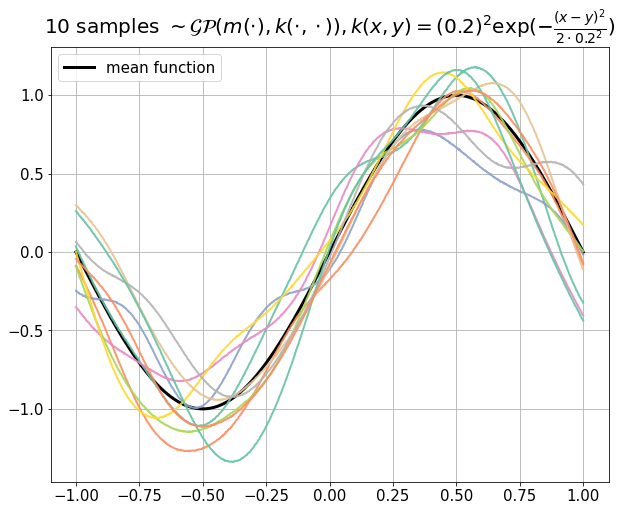

In [ ]:
M = 1001
model = GP_1d(M = M, lengthscale=0.2,sigma = 0.2).to(device).double()
num_samples = 10
samples = model.make_samples()
X = torch.linspace(-1,1,M).view(-1,1)
with torch.no_grad():
    plt.figure(figsize=(10,8),facecolor='white')
    plt.plot(X,model.mean_func(X),'k',linewidth = 3,label="mean function")
    for i in range(num_samples):
        samples = model.make_samples()
        plt.plot(model.Xs.cpu(),samples.cpu(),linewidth= 2,alpha=0.9,color=sns.color_palette("Set2",M)[i])#
    plt.title(f"${{{num_samples}}}$ samples $\\sim \\mathcal{{GP}}(m(\\cdot),k(\\cdot,\\cdot)), k(x,y)=({{{model.sigma}}})^2\\exp(-\\frac{{(x-y)^2}}{{2\\cdot{{{model.lengthscale.item()}}}^2}})$",fontsize=20)
    # plt.ylim([-1,1])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)
    plt.grid()
    # plt.show()
    plt.savefig("GP_samples_result1.png",bbox_inches='tight')

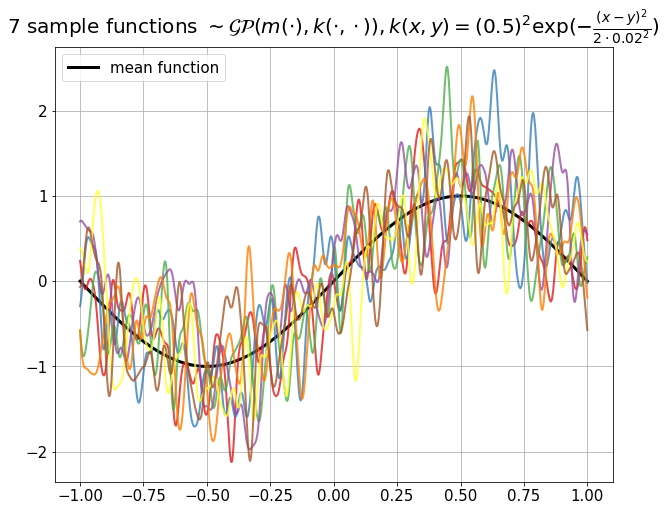

In [ ]:
M = 1001

model = GP_1d(M = M, lengthscale=0.02,sigma = 0.5).to(device).double()
num_samples = 7
samples = model.make_samples()
X = torch.linspace(-1,1,M).view(-1,1)
with torch.no_grad():
    plt.figure(figsize=(10,8),facecolor='white')
    plt.plot(X,model.mean_func(X),'k',linewidth = 3,label="mean function")
    for i in range(num_samples):
        samples = model.make_samples()
        plt.plot(model.Xs.cpu(),samples.cpu(),linewidth= 2,alpha=0.8,color=sns.color_palette("Set1",M)[i])#
    plt.title(f"${{{num_samples}}}$ sample functions $\\sim \\mathcal{{GP}}(m(\\cdot),k(\\cdot,\\cdot)), k(x,y)=({{{model.sigma}}})^2\\exp(-\\frac{{(x-y)^2}}{{2\\cdot{{{model.lengthscale.item()}}}^2}})$",fontsize=20)
    # plt.ylim([-1,1])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)
    plt.grid()
    # plt.show()
    plt.savefig("GP_samples_result2.png",bbox_inches='tight')